# Intracellular Recordings of Aplysia Abdominal Ganglia

In this experiment, a single neuron of the aplysia abdominal ganglion was stimulated with different currents for 5s. We record the firing of this neuron during and after stimulation. In all recordings, a 5s electrical stimulus onsets at ~1.15s. Stimulation was varied between -1.5 $A$ and 1.5 $A$ across 21 steps. Each step was repeated 4 times.

## Step 1: Format Recording
In this first section, we reformat the raw recording into a fiff file, thereby making it compatible with the mne-python package. This will come in handy for preprocessing and analysis.

In [1]:
import neo
import numpy as np
from mne import create_info
from mne.io import RawArray

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define files.
files = ['17n08012.abf', '17n08013.abf', '17n08014.abf', '17n08015.abf']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main body.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for i, f in enumerate(files):

    ## Load recording segments.
    segments = neo.AxonIO(filename='raw/%s' %f).read_block().segments
    
    ## Per recording, there are multiple segments corresponding to
    ## multiple epochs of stimulation at different currents. We
    ## unpack each segment and save it to a separate FIFF file
    ## for later analysis.
    for j, segment in enumerate(segments):
    
        ## Unpack channel traces.
        stim, voltage = segment.analogsignals
    
        ## Concatenate raw recordings.
        data = np.hstack([np.asarray(voltage, dtype=np.float64)  * 1e-3, # mV --> V 
                          np.asarray(stim, dtype=np.float64)
                         ]).T
        
        ## Create info object.
        sfreq = float(stim.sampling_rate)
        ch_names = ['voltage', 'stim']
        ch_types = ['bio', 'stim']
        
        info = create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
        
        ## Create Raw object.
        raw = RawArray(data, info, verbose=False)

        ## Save Raw object.
        raw.save('raw/aplysia_%s%0.2d_raw.fif' %(i,j), overwrite=True, verbose=False)

print('Done.')

Done.


# Step 2: Preprocess Recordings
The end-product of the preprocessing step should be a single DataFrame capturing the onsets and magnitude of each spike during and after stimulation. (We will use this information later to calculate F-I curves for the neuron. To produce this information, we complete the following steps:

1. **Apply highpass filter:** Filter the voltage recording at 1 Hz to remove slow-oscillating trends from the data.
2. **Peak detection:** Identity the time and magnitude of the peak of each action potential during and after stimulation. 
3. **Assemble as DataFrame:** Store the outputs of peak detection in addition to other important metadata information (i.e. recording, during/after stimulation).

In [2]:
import os
import numpy as np
from mne.io import Raw
from mne import pick_channels
from pandas import DataFrame, concat
from scipy.ndimage import measurements

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parmaters.
files = sorted([f for f in os.listdir('raw') if f.endswith('fif')])
stimulation = np.linspace(-1.5,1.5,21).round(2)

## Filtering paramters.
hp = 1
lp = None

## Amplitude thresholding.
threshold = 20

## Timing parameters.
stim_on  = 1.156 #s
stim_off = 6.156 #s

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define useful functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def peak_finder(x0, thresh):
    '''Simple peak finding algorithm.'''
    assert x0.ndim == 1
    clusters, ix = measurements.label(x0 > thresh)
    if not ix: return np.array([]), np.array([])
    peak_loc = np.concatenate(measurements.maximum_position(x0, labels=clusters, index=np.arange(ix)+1))
    peak_mag = measurements.maximum(x0, labels=clusters, index=np.arange(ix)+1)
    return peak_loc, peak_mag

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

df = []
for i, f in enumerate(files):
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and preprocess data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Load data.
    raw = Raw('raw/%s' %f, preload=True, verbose=False)

    ## Filter data.
    picks = pick_channels(raw.ch_names, include=['voltage'])
    raw = raw.filter(hp, lp, picks=picks, phase='zero', verbose=False)

    ## Extract recording.
    data, times = raw.get_data(return_times=True)
    voltage, stim = data
    voltage *= 1e3
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Peak detection.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Peak detection.
    peak_loc, peak_mag = peak_finder(voltage, threshold)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Store info as DataFrame.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Concatenate data.
    X = np.vstack([np.ones_like(peak_loc) * stimulation[i%stimulation.size], 
                   np.ones_like(peak_loc) * i // stimulation.size,
                   times[peak_loc], peak_mag]).T
    
    ## Convert to DataFrame. Append.
    df.append( DataFrame(X, columns=('Stimulation','Recording','Time','Magnitude')) )
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Assemble DataFrames.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Concatenate DataFrames.
df = concat(df)

## Remove pre-stimulation spikes.
df = df[df.Time > stim_on]

## Demarcate spikes as during or after stimulation.
df['Period'] = np.where(df['Time'] > stim_off, 'Post', 'During')

## Remove any spikes more than 3 standard deviations from mean.
## We threshold spikes to remove voltage artifacts from the 
## application of current to the cell.
df = df[ np.logical_and( df.Magnitude > df.Magnitude.mean() + -3 * df.Magnitude.std(),
                         df.Magnitude < df.Magnitude.mean() +  3 * df.Magnitude.std()) ]

## Save DataFrame.
df.to_csv('spikes.csv', index=False)
print('Done.')

Done.


## Step 3: Analyze Spike Rates

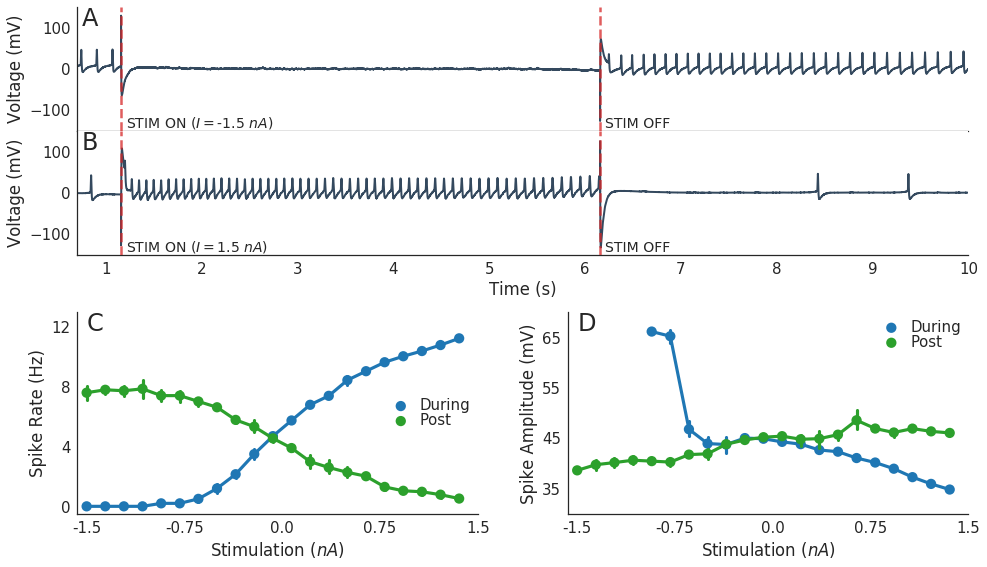

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pandas import Series, read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Analyze spike rates.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
df = read_csv('spikes.csv')

## Compute F-I curves.
gb = df.groupby(['Recording','Stimulation','Period'])
fi = gb.Time.count().reset_index()
fi['Time'] /= np.where(fi['Period']=='During', 5, 10-6.156) # Normalize by duration.

## Insert missing points.
for s in [-1.5, -1.35, -1.2, -1.05]:
    fi = fi.append( Series([0, s, 'During', 0], fi.columns), ignore_index=True)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Open canvas for plotting.
fig = plt.figure(figsize=(15,8))

## Plot representative timecourses.
gs = gridspec.GridSpec(2, 1)
gs.update(left=0.125, right=0.95, bottom=0.55,  top=0.98, hspace=0.0)

for i, f, label, text in zip(range(2), ['aplysia_000_raw.fif', 'aplysia_020_raw.fif'], [-1.5, 1.5], ['A','B']):
    
    ## Load, filter, and extract data.
    raw = Raw('raw/%s' %f, preload=True, verbose=False)
    raw = raw.filter(1, None, picks=picks, phase='zero', verbose=False)
    data, times = raw.get_data(start=raw.time_as_index(0.7)[0], return_times=True)

    ## Plot.
    ax = plt.subplot(gs[i])
    ax.plot(times, data[0] * 1e3, linewidth=2, color="#34495e")
    ax.vlines([stim_on, stim_off], -150, 150, linewidth=2.5, linestyle='--', color='#d62728', alpha=0.75, zorder=90)
    
    ## Add information.
    ax.set(xlim=(times.min(), times.max()), xticks=[], ylim=(-150,150), yticks=np.linspace(-100,100,3), 
           ylabel='Voltage (mV)')
    ax.text(0.75, 150, text, va='top', ha='left', fontsize=24)
    ax.text(stim_on+5e-2, -150, r'STIM ON ($I=$%s $nA$)' %label, va='bottom', ha='left', fontsize=14)
    ax.text(stim_off+5e-2, -150, 'STIM OFF', va='bottom', ha='left', fontsize=14)
    
ax.set(xlim=(times.min(), times.max()), xticks=np.arange(0,11), xlabel='Time (s)')

## Plot spike information.
gs = gridspec.GridSpec(1, 2)
gs.update(left=0.125, right=0.95, bottom=0.1, top=0.45, hspace=0.0, wspace=0.225)

## Plot F-I curves.
ax = plt.subplot(gs[0])
sns.pointplot('Stimulation', 'Time', 'Period', data=fi, hue_order=['During','Post'],
              palette=['#1f77b4', '#2ca02c'], ci=95, ax=ax)
ax.set(xticks=np.linspace(0,21,5), xticklabels=np.linspace(-1.5,1.5,5), xlabel=r'Stimulation ($nA$)',
            ylim=(-0.5,13), yticks=np.arange(0,13,4), ylabel='Spike Rate (Hz)')
ax.legend(loc=7, borderpad=0, labelspacing=0, handletextpad=0.25)
ax.text(0, 13, 'C', va='top', ha='left', fontsize=24)

## Plot magnitude.
ax = plt.subplot(gs[1])
sns.pointplot('Stimulation', 'Magnitude', 'Period', data=df, hue_order=['During','Post'],
              palette=['#1f77b4', '#2ca02c'], ci=95, ax=ax)
ax.set(xticks=np.linspace(0,21,5), xticklabels=np.linspace(-1.5,1.5,5), xlabel=r'Stimulation ($nA$)',
            ylim=(30,70), yticks=np.arange(35,70,10), ylabel='Spike Amplitude (mV)')
ax.legend(loc=1, borderpad=0, labelspacing=0, handletextpad=0.25)
ax.text(0, 70, 'D', va='top', ha='left', fontsize=24)

sns.despine()
plt.savefig('aplysia.png', dpi=300)